# Lazy evaluation for vertical interpolation

In [1]:
import numpy as np
import xarray as xr

In [2]:
from dask import array as darr

## Some artificial data

In [3]:
lon = xr.DataArray(darr.linspace(-180, 180, 60), dims=("lon", ), name="lon")
lat = xr.DataArray(darr.linspace(-90, 90, 30), dims=("lat", ), name="lat")
depth = xr.DataArray(darr.linspace(0, - 1000, 10), dims=("depth", ), name="depth")

In [4]:
temperature = (
    - 2.0  # coldest temp
    + (15 + 15 * darr.sin(darr.deg2rad(lon)) * darr.cos(darr.deg2rad(lat)))  # some pattern between 0 and 30 deg
    * darr.exp(- abs(depth) / 200)  # vertical decay with 200m scale
)
temperature = temperature.rename("temperature")
temperature = temperature.assign_coords(
    {
        "lon": lon,
        "lat": lat,
        "depth": depth,
    }
)

temperature

<xarray.DataArray 'temperature' (lon: 60, lat: 30, depth: 10)>
dask.array<add, shape=(60, 30, 10), dtype=float64, chunksize=(60, 30, 10), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -173.9 -167.8 -161.7 ... 167.8 173.9 180.0
  * lat      (lat) float64 -90.0 -83.79 -77.59 -71.38 ... 71.38 77.59 83.79 90.0
  * depth    (depth) float64 0.0 -111.1 -222.2 -333.3 ... -777.8 -888.9 -1e+03

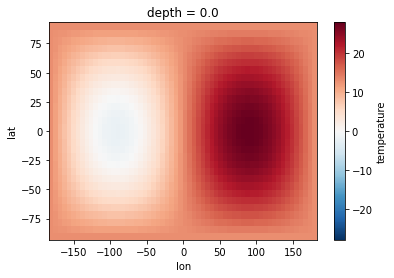

In [5]:
temperature.isel(depth=0).plot(x="lon", y="lat")

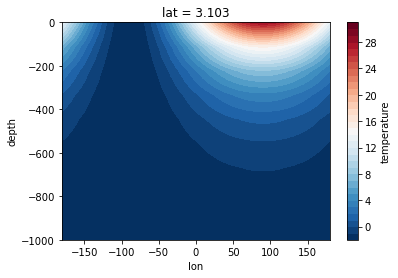

In [6]:
temperature.sel(lat=0, method="nearest").plot.contourf(x="lon", y="depth", levels=np.arange(-2, 32))

## Let's look for the depth of the 0 degree isotherm

### Nearest

In [7]:
target_temp = 0.0

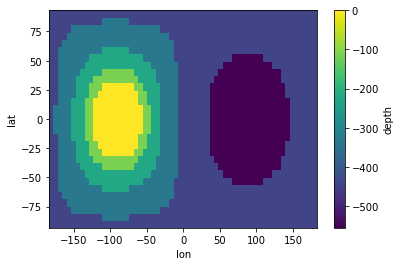

In [8]:
# note we need to evaluate the indexer here
nearest_depth = depth.isel(
    depth=abs(temperature - target_temp).argmin("depth").compute()
)

nearest_depth.plot(x="lon", y="lat")

### Nearest, alternative formulation

In [9]:
# this is all lazy:
nearest_depth_alt = depth.where(
    abs(temperature - target_temp) == abs(temperature - target_temp).min("depth")
).min("depth")

nearest_depth_alt

<xarray.DataArray 'depth' (lon: 60, lat: 30)>
dask.array<nanmin-aggregate, shape=(60, 30), dtype=float64, chunksize=(60, 30), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -173.9 -167.8 -161.7 ... 167.8 173.9 180.0
  * lat      (lat) float64 -90.0 -83.79 -77.59 -71.38 ... 71.38 77.59 83.79 90.0

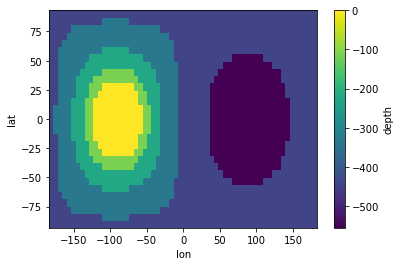

In [10]:
nearest_depth_alt.plot(x="lon", y="lat")

In [11]:
# zero if equal:
(nearest_depth - nearest_depth_alt).std().compute()

<xarray.DataArray 'depth' ()>
array(0.)

### Interpolation approaches

Only works for monotonic.

In [12]:
index_last_warmer = (
    (temperature >= target_temp).sum("depth") - 1
)
index_first_colder = index_last_warmer + 1

Note these can be out of range:

In [13]:
index_last_warmer.min().compute(), index_last_warmer.max().compute()

(<xarray.DataArray 'temperature' ()>
 array(-1),
 <xarray.DataArray 'temperature' ()>
 array(4))

In [14]:
index_first_colder.min().compute(), index_first_colder.max().compute()

(<xarray.DataArray 'temperature' ()>
 array(0),
 <xarray.DataArray 'temperature' ()>
 array(5))

So we regularize:

In [15]:
index_last_warmer += (index_last_warmer < 0)
index_last_warmer -= (index_last_warmer > len(depth))

index_first_colder += (index_first_colder < 0)
index_first_colder -= (index_first_colder > len(depth))

In [16]:
index_last_warmer.min().compute(), index_last_warmer.max().compute()

(<xarray.DataArray 'temperature' ()>
 array(0),
 <xarray.DataArray 'temperature' ()>
 array(4))

In [17]:
index_first_colder.min().compute(), index_first_colder.max().compute()

(<xarray.DataArray 'temperature' ()>
 array(0),
 <xarray.DataArray 'temperature' ()>
 array(5))

Bute

Now do a standard linear regression:

In [18]:
z_index = xr.DataArray(
    darr.arange(len(depth)),
    dims=("depth", ),
    coords={"depth": depth},
)
z_index

<xarray.DataArray 'arange-2300c890afba0995f2c99810b5790497' (depth: 10)>
dask.array<arange, shape=(10,), dtype=int64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.0 -111.1 -222.2 -333.3 ... -777.8 -888.9 -1e+03

In [19]:
mask_last_warmer = (z_index == index_last_warmer)
mask_last_warmer

<xarray.DataArray (depth: 10, lon: 60, lat: 30)>
dask.array<eq, shape=(10, 60, 30), dtype=bool, chunksize=(10, 60, 30), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.0 -111.1 -222.2 -333.3 ... -777.8 -888.9 -1e+03
  * lon      (lon) float64 -180.0 -173.9 -167.8 -161.7 ... 167.8 173.9 180.0
  * lat      (lat) float64 -90.0 -83.79 -77.59 -71.38 ... 71.38 77.59 83.79 90.0

In [20]:
mask_first_colder = (z_index == index_first_colder)
mask_first_colder

<xarray.DataArray (depth: 10, lon: 60, lat: 30)>
dask.array<eq, shape=(10, 60, 30), dtype=bool, chunksize=(10, 60, 30), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.0 -111.1 -222.2 -333.3 ... -777.8 -888.9 -1e+03
  * lon      (lon) float64 -180.0 -173.9 -167.8 -161.7 ... 167.8 173.9 180.0
  * lat      (lat) float64 -90.0 -83.79 -77.59 -71.38 ... 71.38 77.59 83.79 90.0

In [21]:
z0 = depth.where(mask_last_warmer).min("depth")
z1 = depth.where(mask_first_colder).min("depth")

t0 = temperature.where(mask_last_warmer).min("depth")
t1 = temperature.where(mask_first_colder).min("depth")

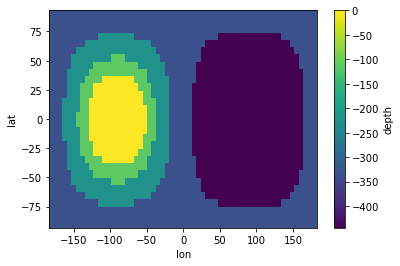

In [22]:
z0.plot(x="lon", y="lat");

In [23]:
offset = (
    (z1 - z0) * (target_temp - t0) / (t1 - t0)
)

# make sure to catch where z1 = z0
offset = offset.fillna(0)

In [24]:
offset

<xarray.DataArray (lon: 60, lat: 30)>
dask.array<where, shape=(60, 30), dtype=float64, chunksize=(60, 30), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -173.9 -167.8 -161.7 ... 167.8 173.9 180.0
  * lat      (lat) float64 -90.0 -83.79 -77.59 -71.38 ... 71.38 77.59 83.79 90.0

In [25]:
interpolated_depth = z0 + offset

interpolated_depth

<xarray.DataArray (lon: 60, lat: 30)>
dask.array<add, shape=(60, 30), dtype=float64, chunksize=(60, 30), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -173.9 -167.8 -161.7 ... 167.8 173.9 180.0
  * lat      (lat) float64 -90.0 -83.79 -77.59 -71.38 ... 71.38 77.59 83.79 90.0

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


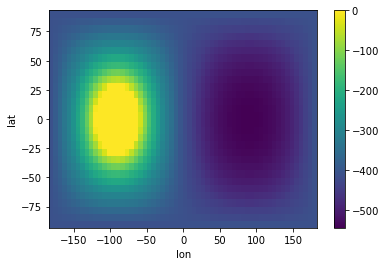

In [26]:
interpolated_depth.plot(x="lon", y="lat");

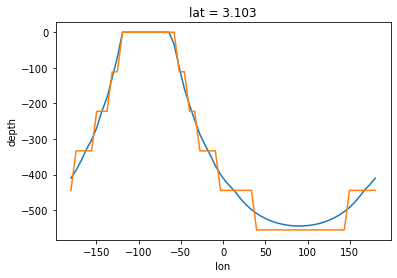

In [27]:
interpolated_depth.sel(lat=0, method="nearest").plot(label="interolated")
nearest_depth.sel(lat=0, method="nearest").plot(label="nearest");

## Visualize

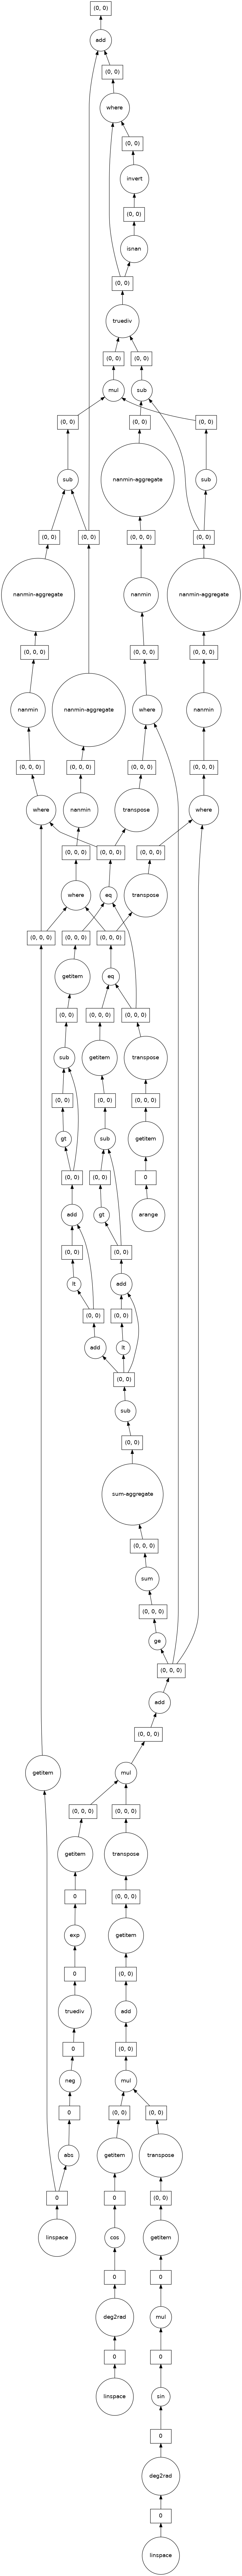

In [28]:
interpolated_depth.data.visualize()